# Team Members

G Sai Keerthi - CS22BTECH11024

Nalavolu Chetana - CS22BTECH11042

Rishitha Surineni - CS22BTECH11050

In [494]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.patches import Ellipse
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [495]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(89)

In [496]:
# Load and normalize data
df = pd.read_csv('data.csv')  # Replace with actual dataset path
scaler = StandardScaler()
data = scaler.fit_transform(df.values)
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

In [497]:
# VAE Parameters
INPUT_DIM = 10
HIDDEN_DIM = 16
BATCH_SIZE = 32
lr = 1e-3
PATIENCE = 20
TOLERANCE = 1e-4
MIN_EPOCHS = 500
MAX_EPOCHS = 5000

In [498]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)
    
    def forward(self, x):
        hidden = F.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_var = self.var(hidden)
        return z_mu, z_var

In [499]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        hidden = F.relu(self.linear(x))
        return self.out(hidden)

In [500]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    
    def forward(self, x):
        z_mu, z_var = self.enc(x)
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        z_sample = eps.mul(std).add_(z_mu)
        reconstructed = self.dec(z_sample)
        return reconstructed, z_mu, z_var

In [501]:
def loss_function(x, x_reconstructed, z_mu, z_var):
    recon_loss = F.mse_loss(x_reconstructed, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
    return recon_loss + kl_loss

In [502]:
# Evaluate latent dimensions
def evaluate_latent_dim(latent_dim, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, max_epochs=MAX_EPOCHS, min_epochs=MIN_EPOCHS, patience=PATIENCE, tolerance=TOLERANCE):
    encoder = Encoder(input_dim, hidden_dim, latent_dim).to(device)
    decoder = Decoder(latent_dim, hidden_dim, input_dim).to(device)
    model = VAE(encoder, decoder).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        x_reconstructed, z_mu, z_var = model(data_tensor)
        loss = loss_function(data_tensor, x_reconstructed, z_mu, z_var)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if loss.item() < best_loss - tolerance:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch >= min_epochs and patience_counter >= patience:
            break
    
    return best_loss, model

In [503]:
latent_dims = [2, 3, 4]
losses = []
models = []
for dim in latent_dims:
    loss, model = evaluate_latent_dim(dim)
    losses.append(loss)
    models.append(model)
    print(f"Latent Dim {dim}: Final Loss = {loss:.2f}")

best_latent_dim = latent_dims[np.argmin(losses)]
model = models[np.argmin(losses)]
print(f"Best Latent Dimension: {best_latent_dim} with Loss: {min(losses):.2f}")
LATENT_DIM = best_latent_dim

Latent Dim 2: Final Loss = 9660.03
Latent Dim 3: Final Loss = 9462.92
Latent Dim 4: Final Loss = 11425.79
Best Latent Dimension: 3 with Loss: 9462.92


In [504]:
# Extract latent distribution centers
model.eval()
with torch.no_grad():
    z_mu, z_var = model.enc(data_tensor)
    latent_centers = z_mu.cpu().numpy()

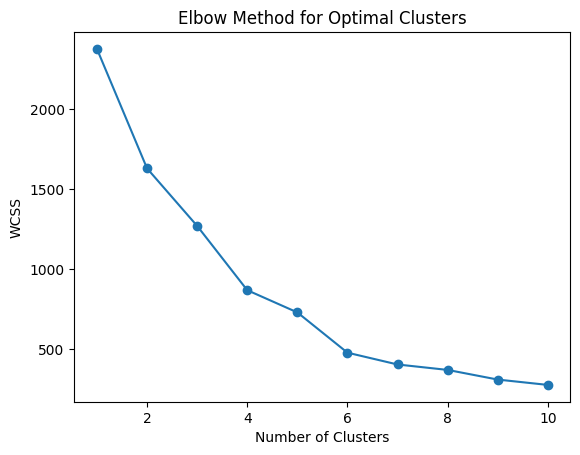

In [505]:
# Elbow method for clustering
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_centers)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(K, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [506]:
optimal_clusters = int(input("Enter the optimal number of clusters based on the Elbow plot: "))
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_centers)

In [507]:
outlier_indices = []
for k in range(optimal_clusters):
    cluster_data = latent_centers[kmeans_labels == k]
    if len(cluster_data) < LATENT_DIM + 1:  # Need more points than dimensions for covariance
        continue
    mean = np.mean(cluster_data, axis=0)
    cov = np.cov(cluster_data.T)
    try:
        inv_cov = np.linalg.inv(cov)
        distances = [mahalanobis(x, mean, inv_cov) for x in cluster_data]
        threshold = np.percentile(distances, 95)  # Top 5% as outliers
        cluster_outliers = np.where(kmeans_labels == k)[0][np.array(distances) > threshold]
        outlier_indices.extend(cluster_outliers)
    except np.linalg.LinAlgError:
        print(f"Cluster {k} skipped: Singular covariance matrix")

boundary_outliers = np.unique(outlier_indices)
print(f"Number of boundary outliers (Mahalanobis): {len(boundary_outliers)}")

Number of boundary outliers (Mahalanobis): 61


In [508]:
cluster_sizes = np.bincount(kmeans_labels)
min_cluster_size = len(latent_centers) * 0.05  # 5% threshold
small_cluster_indices = np.where(cluster_sizes[kmeans_labels] < min_cluster_size)[0]

outlier_indices = np.unique(np.concatenate([boundary_outliers, small_cluster_indices]))

print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Number of Boundary outliers: {len(boundary_outliers)}")
print(f"Number of small cluster outliers: {len(small_cluster_indices)}")
print(f"Total number of outliers: {len(outlier_indices)}")

Optimal number of clusters: 6
Number of Boundary outliers: 61
Number of small cluster outliers: 2
Total number of outliers: 63


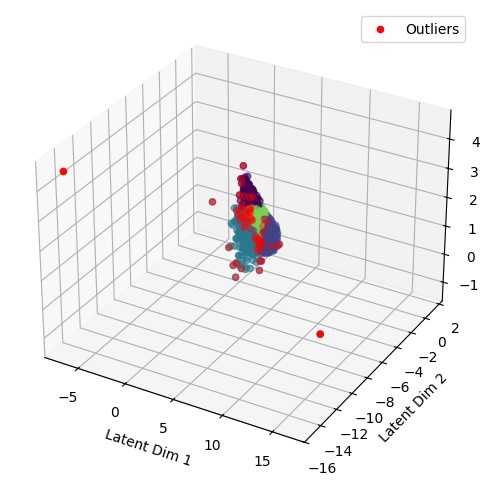

In [509]:
# Visualization (if 3D)
if LATENT_DIM == 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(latent_centers[:, 0], latent_centers[:, 1], latent_centers[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.6)
    ax.scatter(latent_centers[outlier_indices, 0], latent_centers[outlier_indices, 1], latent_centers[outlier_indices, 2], color='red', label='Outliers')
    ax.set_xlabel('Latent Dim 1')
    ax.set_ylabel('Latent Dim 2')
    ax.set_zlabel('Latent Dim 3')
    plt.legend()
    plt.show()
else:
    print("Visualization skipped: Latent dimension is not 3.")

In [510]:
print(cluster_sizes)

[340 339 150   1 368   1]


Explained variance ratio by PCA: 0.93


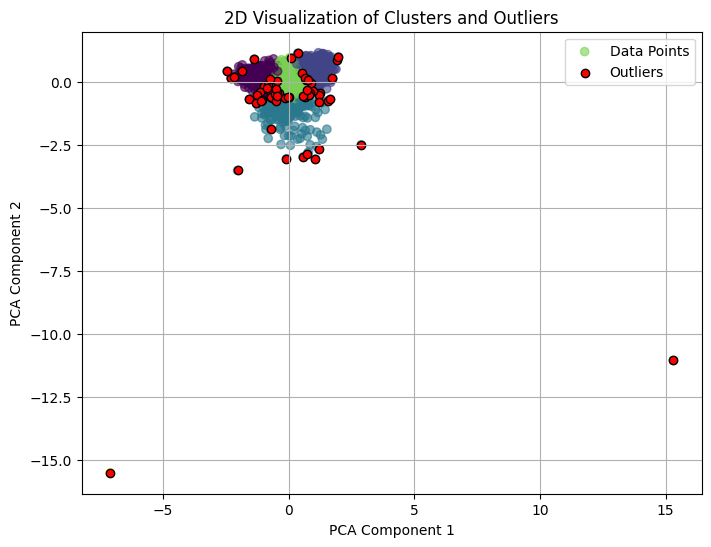

In [511]:
# If latent dimension > 2, reduce to 2D using PCA
if LATENT_DIM > 2:
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_centers)
    print(f"Explained variance ratio by PCA: {pca.explained_variance_ratio_.sum():.2f}")
else:
    # If latent dimension is 2, use it directly; if 1, pad with zeros (rare case)
    latent_2d = latent_centers if LATENT_DIM == 2 else np.pad(latent_centers, ((0, 0), (0, 1)), mode='constant')

# Create 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, label='Data Points')
plt.scatter(latent_2d[outlier_indices, 0], latent_2d[outlier_indices, 1], color='red', label='Outliers', edgecolors='black')
plt.xlabel('Dimension 1' if LATENT_DIM <= 2 else 'PCA Component 1')
plt.ylabel('Dimension 2' if LATENT_DIM <= 2 else 'PCA Component 2')
plt.title('2D Visualization of Clusters and Outliers')
plt.legend()
plt.grid(True)
plt.show()

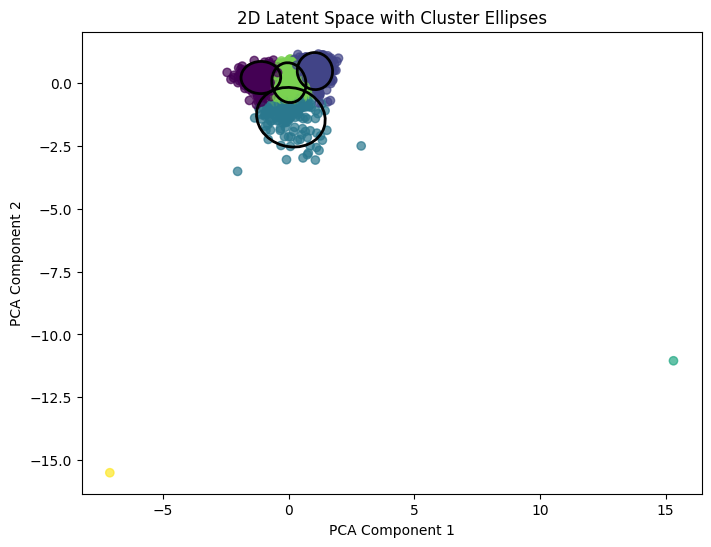

In [512]:
def plot_ellipses(X, labels, ax, n_std=2.0):
    for label in np.unique(labels):
        points = X[labels == label]
        if len(points) < 2:
            continue  # Skip small clusters

        mean = points.mean(axis=0)
        cov = np.cov(points, rowvar=False)
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        order = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

        angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
        width, height = 2 * n_std * np.sqrt(eigenvals)

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,edgecolor='black', facecolor='none', lw=2)
        ax.add_patch(ellipse)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plot_ellipses(latent_2d, kmeans_labels, ax)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Latent Space with Cluster Ellipses')
plt.show()

In [513]:
print("Outlier Indices and Corresponding Latent Space Data Points:")
print("-" * 60)
for idx in outlier_indices:
    # Get the data point from latent_centers
    data_point = latent_centers[idx]
    # Format the output for readability
    print(f"Index: {idx:4d} | Data Point: {data_point}")
for idx in outlier_indices:
    # Get the data point from latent_centers
    data_point = df.iloc[idx]
    # Format the output for readability
    print(f"Index: {idx:4d}")
    print(f"Data Point: {data_point}")


print("-" * 60)
print(f"Total number of outliers: {len(outlier_indices)}")

Outlier Indices and Corresponding Latent Space Data Points:
------------------------------------------------------------
Index:    3 | Data Point: [ 1.0086243  -0.3529237  -0.61427885]
Index:    5 | Data Point: [-0.05128411 -2.8127277  -0.88847846]
Index:   25 | Data Point: [ 2.5477529  -2.5171278  -0.88498354]
Index:   66 | Data Point: [ 0.6074604  -0.27574092 -0.49912953]
Index:   74 | Data Point: [ 0.88800204 -0.41373837 -0.82056195]
Index:  102 | Data Point: [-1.9209999 -3.2003446  1.2987398]
Index:  109 | Data Point: [ 0.5364194  -0.22695391 -0.9647788 ]
Index:  125 | Data Point: [ 0.6225854  -0.33367932 -0.48975992]
Index:  158 | Data Point: [ 0.39415023 -0.47762817 -0.47993487]
Index:  184 | Data Point: [-1.1474948   0.08661856  0.0048774 ]
Index:  201 | Data Point: [-0.488597   -2.8457878  -0.27354524]
Index:  202 | Data Point: [ -6.8713226 -14.835594    4.5505433]
Index:  214 | Data Point: [-0.33224016 -0.2527517   0.37426308]
Index:  225 | Data Point: [ 1.0726643 -0.6629094 -

In [514]:
outlier_data = df.iloc[outlier_indices].reset_index(drop=True)  

print("Outlier Indices and Corresponding Original Data Points:")
print("-" * 60)
outlier_data.index = outlier_indices  
outlier_data.index.name = 'Index'
outlier_data_rounded = outlier_data.round(6)

display(outlier_data_rounded) 

print("-" * 60)
print(f"Total number of outliers: {len(outlier_indices)}")

Outlier Indices and Corresponding Original Data Points:
------------------------------------------------------------


,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
Index,,,,,,,,,,
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
5,0.595378,-0.531958,0.679654,-0.126799,0.455487,0.432046,0.988092,-0.029813,0.768742,-0.054167
25,0.310202,0.714827,0.999397,0.450586,0.999196,0.951493,0.994530,3.957174,-0.567733,-0.042841
66,0.931183,0.999999,0.595929,0.590790,0.839027,0.399217,0.866698,-0.030785,-0.253276,-0.053778
74,0.982466,0.812643,0.946111,0.699623,0.866656,0.542428,0.983148,-0.029685,1.300690,-0.054188
102,0.999988,0.998002,-0.263647,-0.279467,0.000000,0.490375,0.356098,-0.033177,-1.066401,7.486296
109,0.999919,0.864400,0.222306,0.407415,0.000000,-0.135072,0.975022,-0.032202,1.844939,-0.054335
125,0.847642,0.979109,0.698641,0.423866,0.521839,0.138924,0.556171,-0.031146,-0.092162,-0.053949
158,0.999909,0.462412,0.855810,0.135606,0.000000,0.287197,0.679128,-0.033069,0.487825,-0.054250


------------------------------------------------------------
Total number of outliers: 63
